<a href="https://colab.research.google.com/github/JSchoonmaker/blockchain_projects/blob/main/CryptoPunks_EDA_Part_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CryptoPunks EDA

by Jeanna Schoonmaker
Oct 2021

### Installing and importing necessary libraries

In [ ]:
# installing this pkg helps with unnesting some of the json returned from Flipside
!pip install flat-table

In [ ]:
%load_ext google.colab.data_table

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import flat_table
import json
import os
import numpy as np
import pickle
from datetime import datetime

### Next, let's bring in the data. We'll be working from a couple of data sources - a csv of historical punks transactions through 12/30/2020, and then data compiled from an API download from Flipside Crypto for transactions occurring in 2021. 

### First, the easy part - loading the csv

In [ ]:
punks_url = 'https://raw.githubusercontent.com/Omni-Analytics-Group/eth-data-science-course/master/courses/Module%201/punks.csv'

In [ ]:
df = pd.read_csv(punks_url, encoding='unicode_escape')

In [ ]:
df.head()

,Transaction,From,To,Crypto,USD,Txn,ID,Sex,Type,Skin,Slots,Rank
0,Sold,0xf5099e,14715954,25.00,2822.0,2018-11-30,0,Girl,Female,Mid,3,3682560000%
1,Sold,0x00d7c9,10528156,1.60,386.0,2017-07-07,0,Girl,Female,Mid,3,3682560000%
2,Sold,0xc352b5,55241,0.98,320.0,2017-06-23,0,Girl,Female,Mid,3,3682560000%
3,Claimed,NaN,12800693,NaN,NaN,2017-06-23,0,Girl,Female,Mid,3,3682560000%
4,Sold,EliteCat,0xcf6165,60.00,36305.0,2020-11-30,1,Guy,Male,Dark,2,2050240500%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17554 entries, 0 to 17553
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Transaction  17554 non-null  object 
 1   From         7554 non-null   object 
 2   To           17554 non-null  object 
 3   Crypto       7554 non-null   float64
 4   USD          7554 non-null   float64
 5   Txn          17554 non-null  object 
 6   ID           17554 non-null  int64  
 7   Sex          17554 non-null  object 
 8   Type         17554 non-null  object 
 9   Skin         17554 non-null  object 
 10  Slots        17554 non-null  int64  
 11  Rank         17554 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.6+ MB


### It looks like the "Txn" field has our date info, but is in string format. Let's change it to datetime format and then take a look at the max and min dates in this dataset.

In [ ]:
df['Txn']= pd.to_datetime(df['Txn'])

print('The earliest transaction date in the dataset is: ')
print(df.Txn.min())

print('\n\nThe latest transaction date in the dataset is: ')
print(df.Txn.max())

The earliest transaction date in the dataset is: 
2017-06-23 00:00:00


The latest transaction date in the dataset is: 
2020-12-30 00:00:00


### Let's run df.info again to ensure changing Txn to datetime worked.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17554 entries, 0 to 17553
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Transaction  17554 non-null  object        
 1   From         7554 non-null   object        
 2   To           17554 non-null  object        
 3   Crypto       7554 non-null   float64       
 4   USD          7554 non-null   float64       
 5   Txn          17554 non-null  datetime64[ns]
 6   ID           17554 non-null  int64         
 7   Sex          17554 non-null  object        
 8   Type         17554 non-null  object        
 9   Skin         17554 non-null  object        
 10  Slots        17554 non-null  int64         
 11  Rank         17554 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 1.6+ MB


### Looks good! Let's dig into the data more.

In [ ]:
df.describe(include='all', datetime_is_numeric=True) # including "all" as a parameter in df.describe gives us info on non numeric fields as well 

,Transaction,From,To,Crypto,USD,Txn,ID,Sex,Type,Skin,Slots,Rank
count,17554,7554,17554,7554.000000,7554.000000,17554,17554.000000,17554,17554,17554,17554.000000,17554
unique,2,682,1524,NaN,NaN,NaN,NaN,2,5,7,NaN,4007
top,Claimed,Hemba,12800693,NaN,NaN,NaN,NaN,Guy,Male,Mid,NaN,2213293500%
freq,10000,1058,990,NaN,NaN,NaN,NaN,11379,11152,5307,NaN,45
mean,NaN,NaN,NaN,2.389854,867.305033,2018-06-05 21:18:33.592233216,5193.788481,NaN,NaN,NaN,2.778227,NaN
min,NaN,NaN,NaN,0.010000,0.010000,2017-06-23 00:00:00,0.000000,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,0.300000,72.000000,2017-06-23 00:00:00,2906.000000,NaN,NaN,NaN,2.000000,NaN
50%,NaN,NaN,NaN,1.000000,232.500000,2017-06-23 00:00:00,5189.000000,NaN,NaN,NaN,3.000000,NaN
75%,NaN,NaN,NaN,2.900000,1003.250000,2019-12-09 00:00:00,7557.000000,NaN,NaN,NaN,3.000000,NaN
max,NaN,NaN,NaN,189.990000,137522.000000,2020-12-30 00:00:00,9999.000000,NaN,NaN,NaN,7.000000,NaN


### Initial thoughts after first pass at this data:
1. There are 17554 transactions in this dataset, and 10019 of them occurred on Jun 23, 2017 when the punks were first made available. The top transaction type is "Claimed." **More than half of our transactions in this dataset are from the initial 'claims' of the punks.**

2. The "From" and "To" fields indicate the number of unique users who transacted in this dataset. **Interesting that with 10,000 punks, there are only 682 unique users on the selling side of the transaction, with 1524 users on the buying/claiming side of the transaction.**

3. The "Sex," "Type," and "Skin" columns refer to descriptive Punks attributes. The ID is the Punk identifier. "Slots" and "Rank" offer additional data about the sales of the Punks.

4. Ethereum addresses are 40 character hexadecimal strings. However, in this dataset, the "From" and "To" columns, which show the Eth addresses of the users buying and selling the Punks, have been shortened to 8 characters. Some addresses also use a name instead of the shortened hex string.

5. The column titled "Crypto" is referring to the cryptocurrency Ether. **With a mean of 2.39 Eth/857.31 USD and a standard deviation of 6.12 Eth/2833.27 USD, we have a lot of variation in our data.** Let's take a look at it in a scatterplot.

[Text(0.5, 1.0, '2017 - 2020 Punks Purchases')]

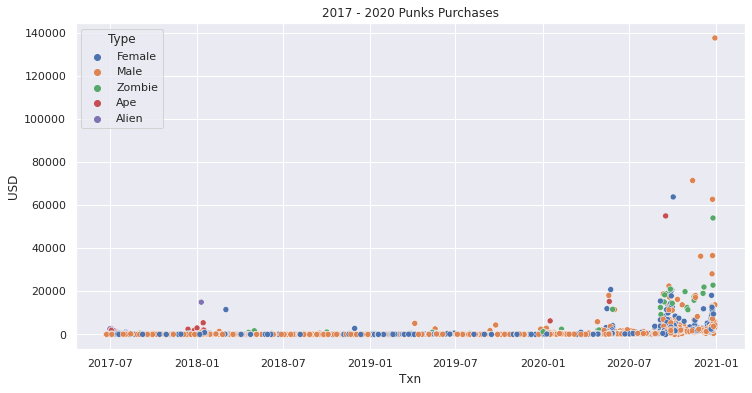

In [ ]:
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
sns.scatterplot(x=df.Txn, y=df.USD, hue = df.Type).set(title='2017 - 2020 Punks Purchases')

### There was very little CryptoPunks sales activity until 2020, but summer through fall of 2020 became much more active. There also appears to be a few outliers in our data.

### It is great to be looking at understandable blockchain data, but what if you need to access raw blockchain data and clean it yourself? 

### Now let's bring in 2021's data from Flipside Crypto using the process I introduced in Part 1.

In [ ]:
url = ('https://api.flipsidecrypto.com/api/v2/queries/99990404-5727-40cb-989a-f9d66738bdca/data/latest')

response = requests.get(url)  

print(f"Request returned {response.status_code} : '{response.reason}'")

payload = response.json()

# uncomment the following lines if you'd like to see the first row of data being returned from the API
# import pprint
# pp = pprint.PrettyPrinter(indent=1)
# pp.pprint(payload[0])

Request returned 200 : 'OK'


### Using json.normalize helps to unpack the json response

In [ ]:
df_flip = pd.json_normalize(payload)

In [ ]:
df_flip.head()

,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_INPUTS,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE
0,11034736,2020-10-11T14:26:11Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,126,"{\n ""fromAddress"": ""0x94de7e2c73529ebf3206aa3...",PunkBought,False,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,None,None,None,None,0x108af624f688703cdeb7100c6ab34b23be301d314c75...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
1,11035115,2020-10-11T15:50:59Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,205,"{\n ""fromAddress"": ""0x037e2847c769d2056450218...",PunkBought,False,0x2d9d722a36cb5fa377366ed725d58199e11aa5da,None,None,None,None,0xf2dfbabb45129581285766ba60a788823fdf4841ac36...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
2,11054057,2020-10-14T13:31:19Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,185,"{\n ""fromAddress"": ""0xa3cb30128532f43fe1c8a9f...",PunkBought,False,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,None,None,None,None,0x540f57b8f591322c51a922b63c363220e85d0280cc19...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
3,11060495,2020-10-15T12:59:51Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,351,"{\n ""fromAddress"": ""0x0713a6c6fd18b2c7e687c4b...",PunkBought,False,0xce810c1ca6390063aca6c16adc095b2f0603c4ba,None,None,None,None,0x748dfa5c2126bbf12077ee3cd3a15011db12408b298b...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft
4,11067502,2020-10-16T14:35:11Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,29,"{\n ""fromAddress"": ""0x927635591fd15026144604f...",PunkBought,False,0x2a538000a53f38d89f37fa43a301cee2c0f9e331,None,None,None,None,0x6c72243fa1dc17ddcb63df7e46c0c07b2b8bca7f5116...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft


### Looks pretty good, but we still have a nested json result in our EVENT_INPUTS column. We'll use flat-table to unpack that

In [ ]:
df_flip['EVENT_INPUTS'] = df_flip['EVENT_INPUTS'].apply(lambda x:json.loads(x))
df_flip = flat_table.normalize(df_flip)

In [ ]:
df_flip.head()

,index,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE,EVENT_INPUTS.value,EVENT_INPUTS.toAddress,EVENT_INPUTS.punkIndex,EVENT_INPUTS.fromAddress
0,0,11034736,2020-10-11T14:26:11Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,126,PunkBought,False,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,None,None,None,None,0x108af624f688703cdeb7100c6ab34b23be301d314c75...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,7500000000000000000,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,4779,0x94de7e2c73529ebf3206aa3459e699fbcdfcd49b
1,1,11035115,2020-10-11T15:50:59Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,205,PunkBought,False,0x2d9d722a36cb5fa377366ed725d58199e11aa5da,None,None,None,None,0xf2dfbabb45129581285766ba60a788823fdf4841ac36...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,4400000000000000000,0x2d9d722a36cb5fa377366ed725d58199e11aa5da,7132,0x037e2847c769d20564502183f524f88baa06b389
2,2,11054057,2020-10-14T13:31:19Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,185,PunkBought,False,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,None,None,None,None,0x540f57b8f591322c51a922b63c363220e85d0280cc19...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,-5946744073709551616,0x792b37c2244ecc0bc18ad193498f17b27efae7d9,2049,0xa3cb30128532f43fe1c8a9f4c19422aa631307a9
3,3,11060495,2020-10-15T12:59:51Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,351,PunkBought,False,0xce810c1ca6390063aca6c16adc095b2f0603c4ba,None,None,None,None,0x748dfa5c2126bbf12077ee3cd3a15011db12408b298b...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,5500000000000000000,0xce810c1ca6390063aca6c16adc095b2f0603c4ba,1234,0x0713a6c6fd18b2c7e687c4b6f5c4dd941c4c3bc0
4,4,11067502,2020-10-16T14:35:11Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,29,PunkBought,False,0x2a538000a53f38d89f37fa43a301cee2c0f9e331,None,None,None,None,0x6c72243fa1dc17ddcb63df7e46c0c07b2b8bca7f5116...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,5000000000000000000,0x2a538000a53f38d89f37fa43a301cee2c0f9e331,6931,0x927635591fd15026144604f223c2313e5909c609


In [ ]:
print('The earliest transaction date in the dataset is: ')
print(df_flip.BLOCK_TIMESTAMP.min())

print('\n\nThe latest transaction date in the dataset is: ')
print(df_flip.BLOCK_TIMESTAMP.max())

The earliest transaction date in the dataset is: 
2020-01-12T18:17:36Z


The latest transaction date in the dataset is: 
2021-10-31T23:09:04Z


In [ ]:
df_flip.describe(include='all')

,index,BLOCK_ID,BLOCK_TIMESTAMP,CONTRACT_ADDRESS,CONTRACT_NAME,EVENT_INDEX,EVENT_NAME,EVENT_REMOVED,TX_FROM_ADDRESS,TX_FROM_ADDRESS_NAME,TX_FROM_LABEL,TX_FROM_LABEL_SUBTYPE,TX_FROM_LABEL_TYPE,TX_ID,TX_SUCCEEDED,TX_TO_ADDRESS,TX_TO_ADDRESS_NAME,TX_TO_LABEL,TX_TO_LABEL_SUBTYPE,TX_TO_LABEL_TYPE,EVENT_INPUTS.value,EVENT_INPUTS.toAddress,EVENT_INPUTS.punkIndex,EVENT_INPUTS.fromAddress
count,14059.000000,1.405900e+04,14059,14059,14059,14059.000000,14059,14059,14059,7,24,24,21,14059,14059,14059,13713,13713,13713,13713,14059.0,14059,14059.0,14059
unique,NaN,NaN,13093,1,1,NaN,1,1,4007,5,7,2,2,13902,1,26,1,1,1,1,2349.0,3841,5233.0,2803
top,NaN,NaN,2021-07-30T23:16:40Z,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,NaN,PunkBought,False,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,suma,idex,general_contract,dapp,0xbdbe5f20bd1dcd5c7ab0c5d5c445aefc8fda504e44e7...,True,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,cryptopunks c token,cryptopunks,token_contract,nft,0.0,0x0000000000000000000000000000000000000000,6989.0,0x577ebc5de943e35cdf9ecb5bbe1f7d7cb6c7c647
freq,NaN,NaN,86,14059,14059,NaN,14059,14059,278,3,8,14,11,45,14059,13713,13713,13713,13713,13713,2133.0,1870,14.0,346
mean,7029.000000,1.214490e+07,NaN,NaN,NaN,131.264813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4058.628052,9.186679e+05,NaN,NaN,NaN,99.104258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,9.267683e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3514.500000,1.185062e+07,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7029.000000,1.220535e+07,NaN,NaN,NaN,110.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,10543.500000,1.293687e+07,NaN,NaN,NaN,193.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_flip.columns

Index(['index', 'BLOCK_ID', 'BLOCK_TIMESTAMP', 'CONTRACT_ADDRESS',
       'CONTRACT_NAME', 'EVENT_INDEX', 'EVENT_NAME', 'EVENT_REMOVED',
       'TX_FROM_ADDRESS', 'TX_FROM_ADDRESS_NAME', 'TX_FROM_LABEL',
       'TX_FROM_LABEL_SUBTYPE', 'TX_FROM_LABEL_TYPE', 'TX_ID', 'TX_SUCCEEDED',
       'TX_TO_ADDRESS', 'TX_TO_ADDRESS_NAME', 'TX_TO_LABEL',
       'TX_TO_LABEL_SUBTYPE', 'TX_TO_LABEL_TYPE', 'EVENT_INPUTS.value',
       'EVENT_INPUTS.toAddress', 'EVENT_INPUTS.punkIndex',
       'EVENT_INPUTS.fromAddress'],
      dtype='object')

### Initial thoughts from this dataset:
1. The csv was much more nicely formatted. As is generally the case, raw data is messy, noisy, and likely needs quite a bit of work before it is understandable and/or useful.

2. This dataset starts on 1/12/2020, overlapping our csv dataset by almost a year. This dataset ends on 10/22/2021.

3. Right from the start, I can see several columns we won't need - as mentioned in Part 1, the contract address refers to the original address of the CryptoPunks contract, so it will be the same value for every column, so we can drop it. Same with the "PunkBought" event_name. Since we filtered for that, all values in that column will be the same. There are several other columns that only have a single "unique" value as shown in the .describe() results, so next steps will include dropping those columns.

4. The To and From addresses in this dataset contain the entire hexadecimal string instead of just the first 8 characters. It does not include any named accounts, so we will need to reconcile named accounts with hex strings if we plan to join the csv dataset with this one.

5. The EVENT_INPUTS.value field looks like our cryptocurrency amount for the transaction - but why is it so high? Because it shows the transaction amount in wei (see here for more info: https://www.investopedia.com/terms/w/wei.asp) which we will convert to Ether by dividing by 1e18.

6. A few key differences from our csv dataset - we don't have the USD conversion in this dataset, so we will need to add that in ourselves. We also don't have any of the Punks attributes listed.

### Before going any further, the negative values in the EVENT_INPUTS.value column should be addressed - I will modify this notebook as the problem is fixed!